# Active Learning

## Imports

In [2]:
import numpy as np           
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.layers import Input, Conv1D, Dropout, Flatten, Dense, MaxPooling1D
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from modAL.models import ActiveLearner
import matplotlib as mpl
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV



## Data Preprocessing(480)

In [40]:
# Constants
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
#FILE_PATHS = [r'New data/test_data.csv', r'New data/test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.read_csv(FILE_PATHS[2], header=None)
y_train = pd.read_csv(FILE_PATHS[3], header=None)
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
n = 480
idx = np.random.choice(range(len(x_train)),
                               size=n,
                               replace=False)
x_train = x_train.iloc[idx]
y_train = y_train.iloc[idx]
x_train = x_train.to_numpy()

y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train,y_train = shuffle(x_train,y_train,random_state=42)
x_test,y_test = shuffle(x_test,y_test,random_state=42)


In [51]:
#print unique labels in y_train and count them

print(x_train.shape)
y_train1 = y_train.argmax(axis=1)
print(np.unique(y_train1, return_counts=True))

(480, 1000)
(array([0, 1, 2], dtype=int64), array([158, 161, 161], dtype=int64))


## Data Preprocessing

In [199]:
# Constants
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.read_csv(FILE_PATHS[2], header=None)
y_train = pd.read_csv(FILE_PATHS[3], header=None)
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
#x_test, y_test = shuffle(x_test, y_test, random_state=5)

# assemble initial data
n_initial = 40
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)




## DBSCAN


In [172]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  
#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# load dataset
data_path = r"train_data.csv"
labels_path = r"train_label.csv"
data = pd.read_csv(data_path, header=None)
labels_true = pd.read_csv(labels_path, header=None).to_numpy().flatten()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Inject noise into 200 random samples
np.random.seed(42)
noise_indices = np.random.choice(data.shape[0], 200, replace=False)
noise = np.random.normal(0, 1000, (200, data.shape[1]))
noisy_data = data.copy()
noisy_data.iloc[noise_indices] += noise

# Standardize the noisy dataset
noisy_data_scaled = scaler.transform(noisy_data)
# Apply PCA
pca = PCA(n_components=50)
data_pca = pca.fit_transform(noisy_data_scaled)
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=3)
dbscan.fit(data_pca)
# Get the cluster labels
labels = dbscan.labels_
# Print the number of clusters and the number of outliers and the number of samples in each cluster 
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)
n_samples_per_cluster = [list(labels).count(i) for i in range(n_clusters)]
print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers}")
print(f"Number of samples in each cluster: {n_samples_per_cluster}")


# compare the detected outliers with the noised data
outlier_indices = [i for i, label in enumerate(labels) if label == -1]
# Convert lists to sets
outlier_set = set(outlier_indices)
noise_set = set(noise_indices)

# Find common indices (correctly detected noisy points)
common_indices = outlier_set.intersection(noise_set)

# Find outliers that were not noisy
outliers_not_noisy = outlier_set - noise_set

# Find noisy points that were not detected as outliers
noisy_not_outliers = noise_set - outlier_set

# Compute percentages
percent_noise_detected = len(common_indices) / len(noise_indices) * 100
#percent_outliers_from_noise = len(common_indices) / len(outlier_indices) * 100

# Print results
print(f"Common Indices: {common_indices}")
print(f"Outliers Not Noisy: {outliers_not_noisy}")
print(f"Noisy Indices Not Outliers: {noisy_not_outliers}")
print(f"Percentage of Noise Detected as Outliers: {percent_noise_detected:.2f}%")
#print(f"Percentage of DBSCAN Outliers That Were Noisy: {percent_outliers_from_noise:.2f}%")

# print the non-outliers
non_outlier_indices = [i for i, label in enumerate(labels) if label != -1]
print(f"Non-outliers: {non_outlier_indices}")

Number of clusters: 2
Number of outliers: 200
Number of samples in each cluster: [493, 237]
Common Indices: {512, 513, 514, 2, 5, 519, 10, 528, 529, 531, 532, 535, 23, 25, 538, 30, 543, 544, 33, 31, 547, 39, 554, 44, 557, 559, 49, 54, 60, 572, 63, 576, 65, 578, 67, 66, 581, 70, 72, 584, 76, 77, 78, 589, 590, 82, 596, 597, 86, 84, 603, 604, 605, 96, 97, 617, 107, 109, 110, 628, 629, 120, 638, 136, 137, 139, 651, 653, 141, 662, 664, 669, 158, 670, 672, 675, 165, 168, 682, 174, 692, 696, 192, 704, 706, 198, 711, 712, 717, 718, 208, 209, 210, 720, 721, 213, 215, 218, 731, 734, 739, 741, 231, 745, 235, 751, 239, 756, 244, 247, 760, 250, 254, 767, 770, 259, 260, 265, 780, 281, 800, 292, 804, 294, 296, 299, 302, 306, 307, 312, 827, 828, 316, 321, 833, 323, 837, 839, 327, 328, 844, 332, 333, 847, 849, 342, 344, 858, 352, 866, 355, 869, 359, 872, 361, 874, 873, 362, 877, 879, 367, 370, 883, 887, 890, 893, 381, 388, 903, 909, 398, 915, 404, 405, 923, 924, 925, 928, 417, 423, 425, 428, 429, 433, 

In [87]:
# Function to add noise to a signal to achieve a desired SNR level
def add_noise_to_signal(x, desired_snr_db):
    """
    Add white Gaussian noise to a signal to achieve a desired SNR level in dB.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Original clean signal.
    desired_snr_db : float
        Desired Signal-to-Noise Ratio (SNR) in decibels.
    
    Returns:
    --------
    noisy_signal : numpy.ndarray
        The signal with added noise.
    noise : numpy.ndarray
        The noise that was added.
    """
    # Calculate signal power (mean squared value) the signal contains RSS in dBm
    signal_power = np.mean(x ** 2)
    
    # Convert SNR from dB to linear scale and compute required noise power
    desired_snr_linear = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr_linear
    
    # Standard deviation of the noise
    noise_std = np.sqrt(noise_power)
    
    # Generate white Gaussian noise with the computed standard deviation
    noise = noise_std * np.random.randn(*x.shape)
    
    # Add the noise to the original signal
    noisy_signal = x + noise
    return noisy_signal, noise

In [171]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  
#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# load dataset
data_path = r"train_data.csv"
labels_path = r"train_label.csv"
data = pd.read_csv(data_path, header=None)
labels_true = pd.read_csv(labels_path, header=None).to_numpy().flatten()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Inject noise into 200 random samples
# select random signals
np.random.seed(42)
random_indices = np.random.choice(data.shape[0], 200, replace=False)
'''
# adding gaussian noise to the selected signals
noise = np.random.normal(30, 50, (200, data.shape[1]))
data.iloc[random_indices] += noise
data.iloc[random_indices] += noise
'''
signals_noisy, noise = add_noise_to_signal(data.iloc[random_indices].to_numpy(), desired_snr_db=5)
# replace the original signals with the noisy signals
noisy_data.iloc[random_indices] = signals_noisy

# Standardize the noisy dataset
noisy_data_scaled = scaler.transform(noisy_data)
# Apply PCA
pca = PCA(n_components=50)
data_pca = pca.fit_transform(noisy_data_scaled)
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=3)
dbscan.fit(data_pca)
# Get the cluster labels
labels = dbscan.labels_
# Print the number of clusters and the number of outliers and the number of samples in each cluster 
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)
n_samples_per_cluster = [list(labels).count(i) for i in range(n_clusters)]
print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers}")
print(f"Number of samples in each cluster: {n_samples_per_cluster}")

Number of clusters: 3
Number of outliers: 500
Number of samples in each cluster: [138, 125, 167]


## CNN Model

In [196]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model1 = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [43]:
# fit model1
history = model1.fit(x_train, y_train, epochs=40, batch_size=30,validation_split=0.3 , verbose=2,shuffle=True)


Epoch 1/40
12/12 - 4s - 354ms/step - accuracy: 0.3333 - loss: 78.1918 - val_accuracy: 0.3056 - val_loss: 2.9626
Epoch 2/40
12/12 - 3s - 214ms/step - accuracy: 0.3363 - loss: 2.1882 - val_accuracy: 0.4028 - val_loss: 1.0975
Epoch 3/40
12/12 - 2s - 196ms/step - accuracy: 0.3601 - loss: 1.0878 - val_accuracy: 0.5556 - val_loss: 1.0890
Epoch 4/40
12/12 - 2s - 201ms/step - accuracy: 0.3452 - loss: 1.0446 - val_accuracy: 0.3750 - val_loss: 1.0940
Epoch 5/40
12/12 - 2s - 203ms/step - accuracy: 0.3631 - loss: 1.0236 - val_accuracy: 0.4444 - val_loss: 1.0836
Epoch 6/40
12/12 - 2s - 208ms/step - accuracy: 0.3423 - loss: 1.0115 - val_accuracy: 0.4028 - val_loss: 1.0818
Epoch 7/40
12/12 - 2s - 196ms/step - accuracy: 0.3333 - loss: 0.9979 - val_accuracy: 0.4236 - val_loss: 1.0714
Epoch 8/40
12/12 - 2s - 195ms/step - accuracy: 0.3512 - loss: 0.9719 - val_accuracy: 0.4653 - val_loss: 1.0692
Epoch 9/40
12/12 - 2s - 193ms/step - accuracy: 0.4077 - loss: 0.9384 - val_accuracy: 0.4792 - val_loss: 1.0611


In [ ]:
loss, accuracy= model1.evaluate(x_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))
print('Loss: %.2f' % (loss))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6900 - loss: 1.5112
Accuracy: 69.00
Loss: 1.51


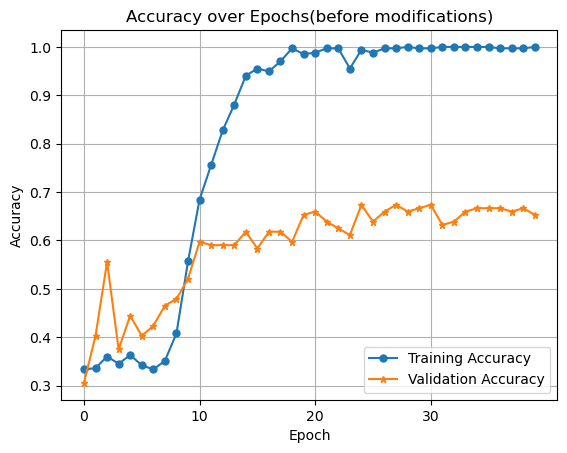

In [45]:
# Access training and validation accuracy directly
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
# Plot training and validation accuracy over epochs
plt.style.use('default')
plt.plot(training_accuracy, label='Training Accuracy', linewidth=1.5, marker='o', markersize=5)
plt.plot(validation_accuracy, label='Validation Accuracy', linewidth=1.5, marker='*', markersize=5)
plt.title('Accuracy over Epochs(before modifications)')
plt.style.use('default')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 40, 10))
plt.show()

In [197]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


### DL Model Evaluation 

In [53]:
history1 = model.fit(x_train, y_train,epochs=60, validation_split=0.3, shuffle=True,batch_size=30,verbose=2)
#classifier.fit(x_train, y_train)

Epoch 1/60
12/12 - 4s - 306ms/step - accuracy: 0.3452 - loss: 42.8187 - val_accuracy: 0.3403 - val_loss: 5.5300
Epoch 2/60
12/12 - 2s - 134ms/step - accuracy: 0.3304 - loss: 5.1031 - val_accuracy: 0.3750 - val_loss: 4.7296
Epoch 3/60
12/12 - 2s - 135ms/step - accuracy: 0.3423 - loss: 4.6268 - val_accuracy: 0.4444 - val_loss: 4.5346
Epoch 4/60
12/12 - 2s - 137ms/step - accuracy: 0.3423 - loss: 4.3934 - val_accuracy: 0.3889 - val_loss: 4.2758
Epoch 5/60
12/12 - 2s - 137ms/step - accuracy: 0.3661 - loss: 4.1069 - val_accuracy: 0.3750 - val_loss: 4.0325
Epoch 6/60
12/12 - 2s - 133ms/step - accuracy: 0.4405 - loss: 3.8797 - val_accuracy: 0.5833 - val_loss: 3.7886
Epoch 7/60
12/12 - 2s - 134ms/step - accuracy: 0.4196 - loss: 3.6881 - val_accuracy: 0.3750 - val_loss: 3.6199
Epoch 8/60
12/12 - 2s - 134ms/step - accuracy: 0.4405 - loss: 3.4659 - val_accuracy: 0.3750 - val_loss: 3.4523
Epoch 9/60
12/12 - 2s - 135ms/step - accuracy: 0.4286 - loss: 3.2764 - val_accuracy: 0.3750 - val_loss: 3.3075


In [54]:
loss, accuracy= model.evaluate(x_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))
print('Loss: %.2f' % (loss))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9759 - loss: 0.6364
Accuracy: 97.00
Loss: 0.66


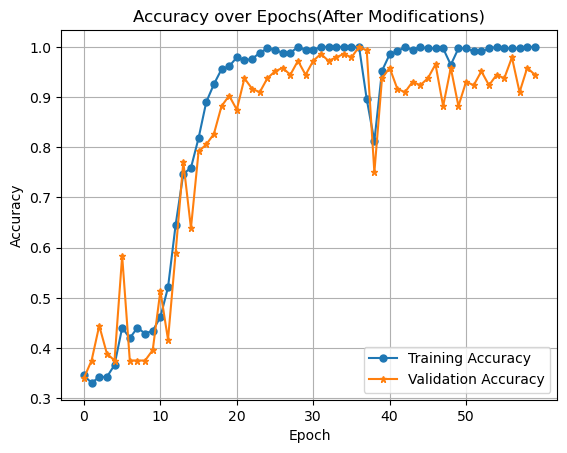

In [55]:
# Access training and validation accuracy directly
training_accuracy = history1.history['accuracy']
validation_accuracy = history1.history['val_accuracy']
# Plot training and validation accuracy over epochs
plt.style.use('default')
plt.plot(training_accuracy, label='Training Accuracy', linewidth=1.5, marker='o', markersize=5)
plt.plot(validation_accuracy, label='Validation Accuracy', linewidth=1.5, marker='*', markersize=5)
plt.title('Accuracy over Epochs(After Modifications)')
plt.style.use('default')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 60, 10))
plt.show()

In [ ]:
print(classifier.score(x_test,y_test))
y_pred = classifier.predict(x_test).argmax(axis=1)
y_test1 = y_test.argmax(axis=1)
print(confusion_matrix(y_test1, y_pred))

## Active Learning 

In [ ]:
#execlude the outliers from the dataset
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)])
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)]
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)

# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [215]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [216]:
# initialize ActiveLearner
learner = ActiveLearner(estimator=classifier,
                        X_training=x_initial,
                        y_training=y_initial,
                        verbose=0)
unqueried_score = learner.score(x_test,y_test)
unqueried_recall = learner.score(x_test,y_test,)
print(unqueried_score)
performance_history = [unqueried_score]
current_epochs = 12
current_batch_size=10
n_queries = 11
# the active learning loop
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(x_pool,n_instances=40)

    queried_x = x_pool[query_idx]
    queried_y = y_pool[query_idx]
    
    
    learner.teach(
    X=queried_x, 
    y=queried_y,
    verbose=1,
    epochs=current_epochs, 
    batch_size=current_batch_size,
    validation_split=0.3 
            )
    

    # remove queried instance from pool
    x_pool = np.delete(x_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)


    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(x_test,y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    # Increment the number of epochs for the next query
    current_epochs += 2
    current_batch_size+=1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.3233333333333333
Query no. 1
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.3757 - loss: 82.6680 - val_accuracy: 0.2083 - val_loss: 8.4522
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.3387 - loss: 21.6026 - val_accuracy: 0.2083 - val_loss: 5.5417
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4159 - loss: 6.8615 - val_accuracy: 0.1250 - val_loss: 4.9240
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.3680 - loss: 4.8396 - val_accuracy: 0.6667 - val_loss: 4.9558
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.3686 - loss: 4.8670 - val_accuracy: 0.6667 - val_loss: 4.9509
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.3384 - loss: 4.8607 - val_accuracy: 0.6667 - val_loss: 4.9039
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4548 - loss: 4.6944 - val_a

### Model Evaluation

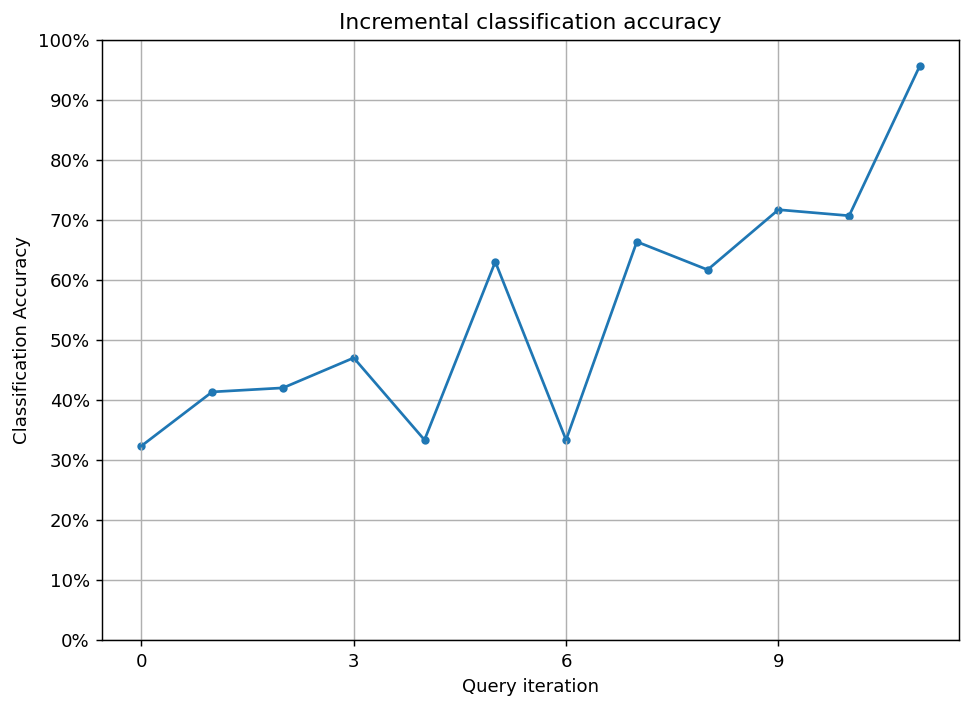

In [224]:
# Plot our performance over time.
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [218]:
y_pred = learner.predict(x_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


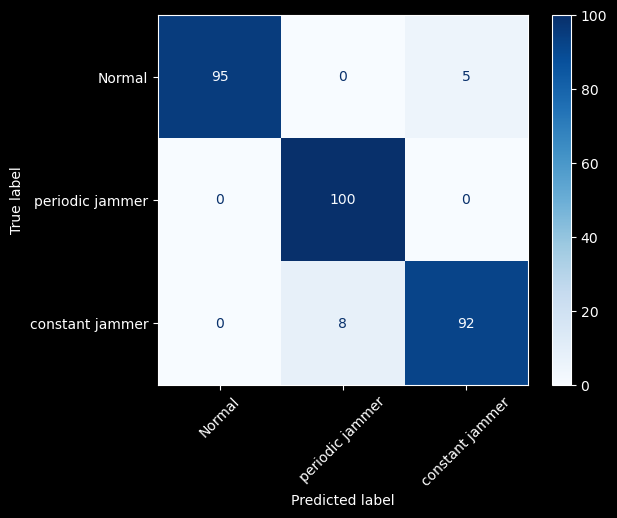

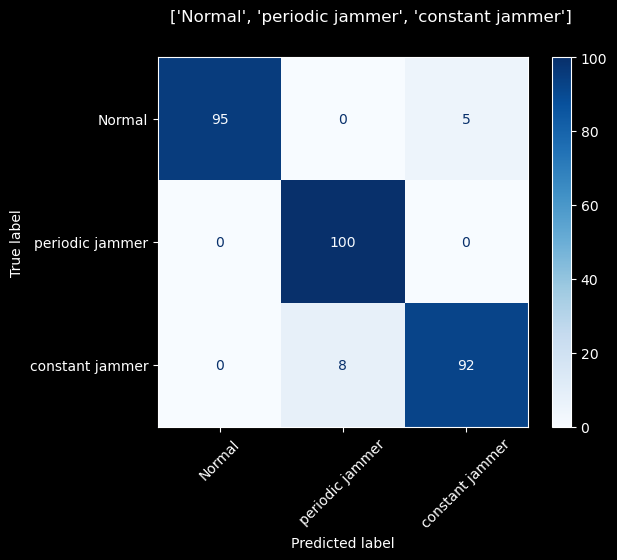

In [222]:

class_names = ['Normal','periodic jammer', 'constant jammer']
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                  display_labels=class_names,
                                                  cmap='Blues',
                                                  xticks_rotation=45)
display.figure_.suptitle(class_names)
plt.show()

In [85]:
print(classification_report(y_true, y_pred, target_names=class_names))


                 precision    recall  f1-score   support

         Normal       0.95      0.99      0.97       100
periodic jammer       0.99      0.95      0.97       100
constant jammer       1.00      1.00      1.00       100

       accuracy                           0.98       300
      macro avg       0.98      0.98      0.98       300
   weighted avg       0.98      0.98      0.98       300



## Active Learning Cycle (monte carlo)

In [ ]:
#execlude the outliers from the dataset
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)])
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)]
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)

# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [54]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [55]:
for i in range(5):

      # initialize ActiveLearner
      learner = ActiveLearner(estimator=classifier,
                              X_training=x_initial,
                              y_training=y_initial,
                              verbose=0)
      unqueried_score = learner.score(x_test,y_test)
      print(unqueried_score)
      performance_history = [unqueried_score]
      current_epochs = 12
      current_batch_size=10
      n_queries = 15


      # the active learning loop
      for idx in range(n_queries):
            print('Query no. %d' % (idx + 1))
            query_idx, query_instance = learner.query(x_pool,n_instances=30)

            queried_x = x_pool[query_idx]
            queried_y = y_pool[query_idx]
            
            
            learner.teach(
            X=queried_x, 
            y=queried_y,
            verbose=0,
            epochs=current_epochs, 
            batch_size=current_batch_size,
            validation_split=0.3 
                  )
            
      
            # remove queried instance from pool
            x_pool = np.delete(x_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)

      
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(x_test,y_test)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
            # Increment the number of epochs for the next query
            current_epochs += 2
            current_batch_size+=1
      performance[i] = np.array(performance_history).reshape(1, len(performance_history))    
      #save as csv
      pd.DataFrame(performance).to_csv('performance.csv', index=False, header=False)
      print("saved")# assemble initial data
      initial_idx = np.random.choice(range(len(x_train)),
                                    size=n_initial,
                                    replace=False)
      x_initial = x_train.iloc[initial_idx]
      y_initial = y_train[initial_idx]
      x_initial = x_initial.to_numpy()

      # generate the pool
      # remove the initial data from the training dataset
      x_pool = np.delete(x_train, initial_idx, axis=0)
      y_pool = np.delete(y_train, initial_idx, axis=0)  
    

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0.3333333333333333
Query no. 1
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy after query 1: 0.3600
Query no. 2
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Accuracy after query 2: 0.4833
Query no. 3
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy after query 3: 0.6400
Query no. 4
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Accuracy after query 4: 0.4833
Query no. 5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy after query 5: 0.4867
Query no. 6
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Accuracy after query 6: 0.5633
Query no. 7
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy after query 7: 0.6933
Query no. 8
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0

### Model Evaluation (monte carlo)

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

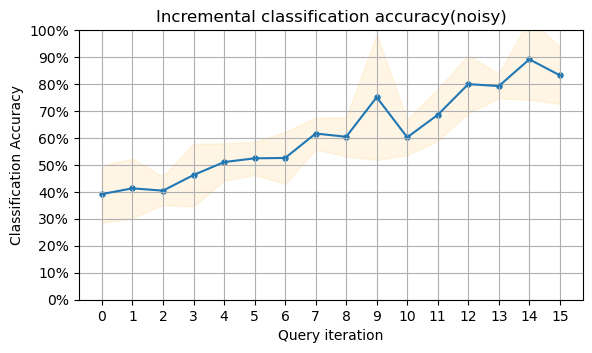

In [66]:
performance = pd.read_csv('performance_300_noisy.csv', header=None)
means = performance.mean()
stds = performance.std()
plt.style.use('default')
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.plot(means)
ax.fill_between(range(len(means)), means-stds, means+stds, alpha=0.1, color='orange')
ax.scatter(range(len(means)), means, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)
#ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.set_title('Incremental classification accuracy(noisy)')
plt.show()
#save the plot
fig.savefig('AL_noisy.png')

## DBSCAN RESULTS

In [79]:
#execlude the outliers from the dataset
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)]).reset_index(drop=True)
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)].reset_index(drop=True)
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None, dtype=float).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
y_train_clean = keras.utils.to_categorical(y_train_clean, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)

# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train_clean)),
                               size=n_initial,
                               replace=False)
x_initial = x_train_clean.iloc[initial_idx]
y_initial = y_train_clean[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train_clean, initial_idx, axis=0)
y_pool = np.delete(y_train_clean, initial_idx, axis=0)

In [81]:
x_train_clean

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
267,-22.9334,-28.6936,-31.9917,-27.6959,-25.7479,-26.3666,-34.1357,-34.1420,-34.4863,-30.7070,...,-50.1202,-25.7648,-29.2171,-26.5607,-46.7541,-35.9334,-25.7262,-30.9042,-31.4655,-25.1208
552,-27.2256,-27.4643,-32.4124,-40.2060,-21.7539,-31.1543,-24.5632,-53.1535,-74.8027,-80.1827,...,-46.9442,-36.5803,-41.4921,-34.7732,-39.6350,-78.1689,-81.1002,-77.0629,-78.5539,-53.2535
250,-34.6612,-25.3435,-40.6624,-27.4371,-30.5687,-26.5026,-36.8333,-23.5702,-24.4215,-33.9803,...,-28.7357,-27.1012,-29.4396,-31.4410,-27.1595,-33.0960,-25.9080,-33.2593,-33.7060,-22.2618
568,-28.8469,-35.2644,-23.3950,-27.5818,-27.8642,-34.9773,-21.7196,-26.6258,-29.8365,-31.9114,...,-23.8965,-33.6058,-37.0172,-37.4146,-32.8172,-32.9320,-37.6042,-27.4306,-28.4860,-30.2567
102,-83.0371,-81.5208,-77.8040,-82.4634,-82.4042,-84.1749,-78.9913,-82.6572,-80.0627,-35.9289,...,-88.6496,-78.6134,-76.8787,-88.2488,-81.6340,-81.0163,-82.1462,-81.2140,-88.2762,-93.0826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,-30.5526,-26.0359,-24.5744,-45.9189,-25.1836,-29.6479,-29.4595,-34.8602,-38.7672,-33.7014,...,-78.5958,-83.7312,-92.3239,-90.7760,-77.4701,-82.0320,-78.6744,-84.9108,-94.6365,-92.4127
163,-86.6360,-80.4890,-84.6841,-81.4996,-82.2666,-85.6136,-80.2412,-79.9112,-96.7660,-91.2677,...,-82.8216,-75.6459,-77.4926,-86.3424,-90.3492,-85.2803,-80.2850,-82.4173,-85.3653,-85.0443
607,-82.4499,-84.4336,-77.6176,-79.6619,-82.2539,-76.3317,-79.1506,-37.2553,-28.3644,-27.9467,...,-83.3527,-79.1650,-81.4456,-82.3252,-86.5415,-86.8811,-83.6738,-88.1276,-73.8277,-83.6024
544,-78.3509,-30.9840,-81.1153,-86.6709,-93.3718,-88.7716,-76.9595,-77.8493,-95.0566,-85.3988,...,-83.1435,-76.1668,-92.3850,-84.8661,-79.9834,-77.0126,-80.1747,-89.2461,-43.9562,-73.7969


In [82]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [83]:
for i in range(5):

      # initialize ActiveLearner
      learner = ActiveLearner(estimator=classifier,
                              X_training=x_initial,
                              y_training=y_initial,
                              verbose=0)
      unqueried_score = learner.score(x_test,y_test)
      print(unqueried_score)
      performance_history = [unqueried_score]
      current_epochs = 12
      current_batch_size=10
      n_queries = 15


      # the active learning loop
      for idx in range(n_queries):
            print('Query no. %d' % (idx + 1))
            query_idx, query_instance = learner.query(x_pool,n_instances=30)

            queried_x = x_pool[query_idx]
            queried_y = y_pool[query_idx]
            
            
            learner.teach(
            X=queried_x, 
            y=queried_y,
            verbose=1,
            epochs=current_epochs, 
            batch_size=current_batch_size,
            validation_split=0.3 
                  )
            
      
            # remove queried instance from pool
            x_pool = np.delete(x_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)

      
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(x_test,y_test)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
            # Increment the number of epochs for the next query
            current_epochs += 2
            current_batch_size+=1
      performance[i] = np.array(performance_history).reshape(1, len(performance_history))    
      #save as csv
      pd.DataFrame(performance).to_csv('performance.csv', index=False, header=False)
      print("saved")# assemble initial data
      initial_idx = np.random.choice(range(len(x_train)),
                                    size=n_initial,
                                    replace=False)
      x_initial = x_train.iloc[initial_idx]
      y_initial = y_train[initial_idx]
      x_initial = x_initial.to_numpy()

      # generate the pool
      # remove the initial data from the training dataset
      x_pool = np.delete(x_train, initial_idx, axis=0)
      y_pool = np.delete(y_train, initial_idx, axis=0)  
    

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0.3333333333333333
Query no. 1
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 1/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3873 - loss: 42.8573 - val_accuracy: 0.4444 - val_loss: 11.5172
Epoch 2/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.3452 - loss: 18.2211 - val_accuracy: 0.2222 - val_loss: 5.6795
Epoch 3/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.3571 - loss: 7.4358 - val_accuracy: 0.4444 - val_loss: 4.6325
Epoch 4/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5597 - loss: 4.5028 - val_accuracy: 0.4444 - val_loss: 4.7419
Epoch 5/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4847 - loss: 4.7007 - val_accuracy: 0.4444 - val_loss: 4.7701
Epoch 6/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5083 - loss: 4.6997 - val_accuracy: 0.4444 - val_loss: 4.7493
Epoch 7/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4625 - loss: 4.7908 - val_accuracy: 0.4444 - val_loss: 4.7183
Epoc

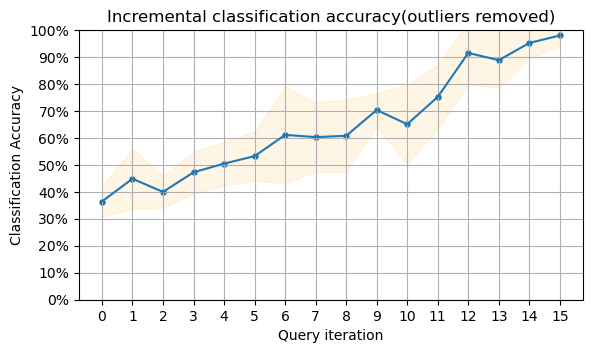

In [13]:
performance = pd.read_csv('performance.csv', header=None)
means = performance.mean()
stds = performance.std()
plt.style.use('default')
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.plot(means)
ax.fill_between(range(len(means)), means-stds, means+stds, alpha=0.1, color='orange')
ax.scatter(range(len(means)), means, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)
#ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.set_title('Incremental classification accuracy(outliers removed)')
plt.show()
#save the plot
fig.savefig('AL.png')

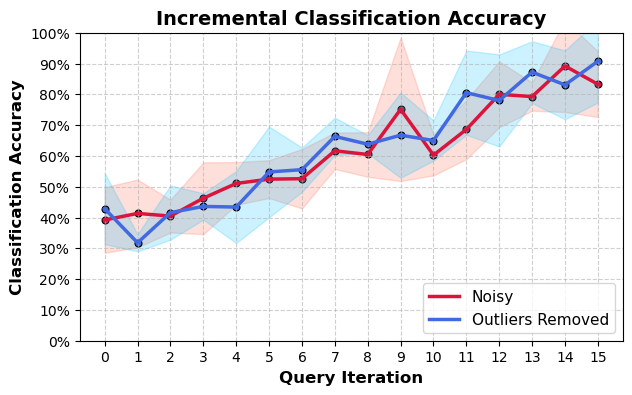

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Load both datasets
performance_noisy = pd.read_csv('performance_300_noisy.csv', header=None)
performance_clean = pd.read_csv('performance_300_clean.csv', header=None)

# Compute means and standard deviations
means_noisy = performance_noisy.mean()
stds_noisy = performance_noisy.std()

means_clean = performance_clean.mean()
stds_clean = performance_clean.std()

plt.style.use('default')  # Better contrast

# Create the figure
fig, ax = plt.subplots(figsize=(7, 4))  # Slightly larger for clarity

# Plot Noisy Data
ax.plot(means_noisy, label='Noisy', color='crimson', linewidth=2.5)
ax.fill_between(range(len(means_noisy)), means_noisy - stds_noisy, means_noisy + stds_noisy, alpha=0.2, color='tomato')
ax.scatter(range(len(means_noisy)), means_noisy, s=25, color='crimson', edgecolor='black', linewidth=0.8)

# Plot Clean Data
ax.plot(means_clean, label='Outliers Removed', color='royalblue', linewidth=2.5)
ax.fill_between(range(len(means_clean)), means_clean - stds_clean, means_clean + stds_clean, alpha=0.2, color='deepskyblue')
ax.scatter(range(len(means_clean)), means_clean, s=25, color='royalblue', edgecolor='black', linewidth=0.8)

# Formatting the graph
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True, linestyle='--', alpha=0.6)

# Labels and title
ax.set_xlabel('Query Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Classification Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Incremental Classification Accuracy', fontsize=14, fontweight='bold')

# Add legend with better visibility
ax.legend(frameon=True, fontsize=11, loc='lower right')

# Show and save the plot
plt.show()
fig.savefig('AL_comparison.png', dpi=300)


In [64]:
data = pd.read_csv('train_data.csv', header=None)
# calculate the mean and standard deviation of each row
mean = data.mean(axis=1)
std = data.std(axis=1)

# create a new DataFrame with the mean and standard deviation
df = pd.DataFrame({'mean': mean, 'std': std})
df

,mean,std
0,-81.051327,12.198565
1,-81.060124,12.016127
2,-81.211296,11.617749
3,-79.723679,12.805523
4,-79.827952,13.709812
...,...,...
925,-60.917163,25.464191
926,-61.368912,25.529634
927,-61.726550,25.422762
928,-61.993678,24.815019
